In [1]:
from os import path
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
%matplotlib inline
import pickle

import sys
sys.path.append("../")  # look one directory up for qca modules, TODO: make a package
from qca import QCA
import measures as ms

In [2]:
# cirq density matrix data
L = 11
T = 100
rhoj_cirq = np.zeros((T, L, 2, 2), dtype=np.complex128)
rhojk_cirq = np.zeros((T, L*(L-1)//2, 4, 4), dtype=np.complex128)
jks = [[j,k] for j in range(L) for k in range(j)]
with open(path.join(der,'density_matrices.pickle'), 'rb') as handle:
    data = pickle.load(handle)
    for t in range(T):
        for j in range(L):
            rhoj_cirq[t, j, :, :] = data[f"t{t}_r0_q{j}"]
        for i, (j, k) in enumerate(jks):
            rhojk_cirq[t, i, :, :] = data[f"t{t}_r0_q{k}_qq{j}"]

In [3]:
# exact and exact+depolarized data
p_exact = dict(
          L=11,
          T=200.0,
          dt=1.0,
          R=6,
          r=1,
          V="H",
          BC="1-00",
          IC="c1_f0",
          E=0.0,
          N=1,
          totalistic=False,
          hamiltonian=False,
          trotter=True,
          symmetric=False
         )
p_depol = copy(p_exact)
p_depol.update({"N":200, "E":0.0068})

Q_exact = QCA(p_exact, der=r"/home/lhillber/documents/research/cellular_automata/qeca/qca/data/")
Q_depol = QCA(p_depol, der=r"/home/lhillber/documents/research/cellular_automata/qeca/qca/data/")

rhoj_exact= Q_exact.rhoj[:T]
rhojk_exact= Q_exact.rhojk[:T]

rhoj_depol= Q_depol.rhoj[:T]
rhojk_depol= Q_depol.rhojk[:T]
Q_exact.close()
Q_depol.close()

In [4]:
def C_and_Y(rhoj, rhojk, order=2):
    s2 = np.array([ms.get_entropy2(rhojk, order=order) for rhojk in rhojk])
    s1 = np.array([ms.get_entropy(rhoj, order=order) for rhoj in rhoj])
    MI = np.array([ms.get_MI(ss1, ss2) for ss1, ss2 in zip(s1, s2)])
    C = np.array([ms.network_clustering(M) for M in MI])
    Y = np.array([ms.network_disparity(M) for M in MI])
    return C, Y

In [5]:
def fidelity(rho1, rho2):
    return np.array([[ms.fidelity(r, s) for r, s in zip(r1, r2)] for r1, r2 in zip(rho1, rho2)])

In [6]:
# network measures
C_exact, Y_exact = C_and_Y(rhoj_exact, rhojk_exact)
C_depol, Y_depol = C_and_Y(rhoj_depol, rhojk_depol)
C_cirq, Y_cirq = C_and_Y(rhoj_cirq, rhojk_cirq)


C_depol_diff = np.abs(C_depol - C_exact)
C_cirq_diff = np.abs(C_cirq - C_exact)
Y_depol_diff = np.abs(Y_depol - Y_exact)
Y_cirq_diff = np.abs(Y_cirq - Y_exact)

In [7]:
#  Fidelity
F_depol = fidelity(rhoj_depol, rhoj_exact)
F2_depol = fidelity(rhojk_depol, rhojk_exact)
F_cirq = fidelity(rhoj_cirq, rhoj_exact)
F2_cirq = fidelity(rhojk_cirq, rhojk_exact)

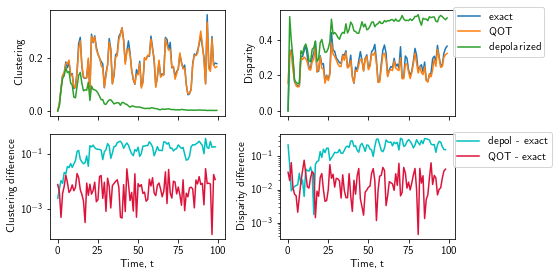

In [8]:
# network measure plots
fig, axs = plt.subplots(2, 2, sharex="col", figsize=(8,4))
axs[0,0].plot(C_exact, label="exact")
axs[0,0].plot(C_cirq, label="QOT")
axs[0,0].plot(C_depol, label="depolarized")
axs[0,0].set_ylabel(r"Clustering")

axs[1,0].plot(C_depol_diff[1:], c="c")
axs[1,0].plot(C_cirq_diff[1:], c="crimson")
axs[1,0].set_yscale("log")
axs[1,0].set_ylabel("Clustering difference")
axs[1,0].set_xlabel(r"Time, t")

axs[0,1].plot(Y_exact, label="exact")
axs[0,1].plot(Y_cirq, label="QOT")
axs[0,1].plot(Y_depol, label="depolarized")
axs[0,1].set_ylabel(r"Disparity")
axs[0,1].legend(loc="center", bbox_to_anchor=(1.25,0.79))

axs[1,1].plot(Y_depol_diff[1:], c="c", label=r"depol - exact")
axs[1,1].plot(Y_cirq_diff[1:], c="crimson", label=r"QOT - exact")
axs[1,1].set_yscale("log")
axs[1,1].set_ylabel("Disparity difference")
axs[1,1].set_xlabel(r"Time, t")
axs[1,1].legend(loc="center", bbox_to_anchor=(1.27,0.85))

plt.tight_layout()
plt.savefig("cirq-depol_network_measure_accuracy.pdf")

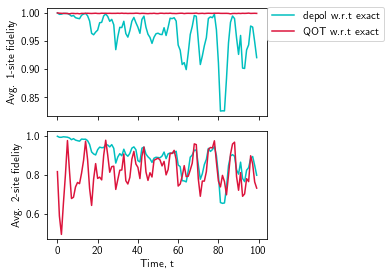

In [9]:
# Fidelity plots
fig, axs = plt.subplots(2, 1, sharex="col")
axs[0].plot(np.mean(F_depol, axis=1), c="c", label="depol w.r.t exact")
axs[0].plot(np.mean(F_cirq, axis=1), c="crimson", label="QOT w.r.t exact")
axs[0].set_ylabel("Avg. 1-site fidelity")
axs[0].legend(loc="center", bbox_to_anchor=(1.27, 0.85))

axs[1].plot(np.mean(F2_depol, axis=1), c="c")
axs[1].plot(np.mean(F2_cirq, axis=1), c="crimson")
axs[1].set_ylabel("Avg. 2-site fidelity")
axs[1].set_xlabel("Time, t")
plt.tight_layout()
plt.savefig("cirq-depol_fidelity.pdf")

In [10]:
# location of network measure data
der = r"/home/lhillber/documents/research/cellular_automata/qeca/qca/data/circ"
# load .npz files
dat1 = np.load(path.join(der, "exact_clustering_and_disparity.npz"))
dat2 = np.load(path.join(der, "clustering_and_disparity.npz"))

C_cirq_2 = dat2["arr_1"]

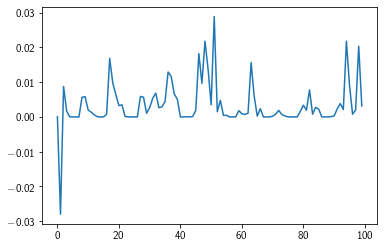

In [11]:
plt.plot(C_cirq_2-C_cirq)